# **Food Image Dataset: On my Own**
## **Universidad Nacional de Colombia Sede Medellín**


## Análisis de imágenes en platos de comida típicos de Antioquía: un enfoque de visión por computadora para el conteo de carbohidratos en personas con diabetes mellitus

**Estudiante :** Andrés Felipe Jaramillo Tamayo.
**Identificación :** Cédula de Ciudadanía, 1.037.663.920

• **Director propuesto :** Ph.D. M.Sc. Juan David Ospina Arango.
**Departamento del director :** Ciencias de la Computación y la Decisión.
**Cédula :** 71364925
**Correo :** jdospina@unal.edu.co

• **Codirector propuesto # 1 :** Ph.D. M.Sc. Freddy Bolaños Martínez
**Departamento del codirector :** Energía Eléctrica y Automática.
**Cédula :** 94511803
**Cédula :** fbolanosm@unal.edu.co

• **Codirectora propuesta # 2 :** Ph.D. M.Sc. Laura Lema Pérez.
**Institución de la codirectora :** Universidad Noruega de Ciencia y Tecnología
(NTNU) / Departamento de Ingeniería Cibernética.
**Cédula :** 1128421450
**Cédula :** llemap@unal.edu.co

• **Codirectora propuesta # 3 :** Ph.D. M.Sc. Lina María Gómez E.
**Departamento de la codirectora :** Departamento de Procesos y Energía
**Cédula :**
**Cédula :** limage@unal.edu.co




## **Justificación**

### **¿Qué?**
El problema central que se abordará es la ineficacia del enfoque tradicional de control de la ingesta de carbohidratos mediante un diario en papel en el manejo de la diabetes mellitus en Antioquia. Específicamente, se destaca que este enfoque obsoleto y poco preciso dificulta el control nutricional de las personas con diabetes, aumenta el riesgo de complicaciones de salud y conlleva a costos médicos adicionales. Además, impacta negativamente en su vida social y emocional al limitar su participación en actividades sociales y su autonomía.



### **¿Para qué?**
Para abordar este problema, se propone la implementación de técnicas avanzadas, como el procesamiento de imágenes y el aprendizaje automático, con el objetivo de cuantificar los carbohidratos en los alimentos. La finalidad de esta propuesta es mejorar la precisión en la administración de insulina y el control glucémico de las personas con diabetes. En última instancia, se busca mitigar los efectos negativos del enfoque tradicional mencionado, mejorando la calidad de vida y la gestión de la salud de las personas afectadas por la diabetes en Antioquia.

### **¿Cómo?**

Para abordar el problema, se propone el diseño de un pipeline de procesamiento de extremo a extremo (end-to-end) basado en PyTorch y Hugging Face API, estructurado en tres etapas principales:

1. Segmentación semántica.
Se entrenarán redes neuronales convolucionales de última generación, como U-Net o UperNet-ConvNeXt, utilizando un banco de imágenes propio, anotado a nivel de píxel. El objetivo es identificar y clasificar cada porción de alimento presente en la escena.

2. Estimación volumétrica y cálculo de carbohidratos.
A partir de las máscaras segmentadas, se aplicará un método basado en Look Up Table (LUT). Este método utiliza un archivo .csv derivado de imágenes del ATLAS (libro estándar de porciones utilizado por nutricionistas para estimar gramajes a partir de representaciones visuales). A partir de esas imágenes, se construyó un factor de conversión entre el porcentaje de cobertura en la imagen (relación área sobre área, A/A) y la cantidad estimada de gramos por porción.




Instalación de paquetes haciendo de uso de pip como instalador

In [130]:
%pip install cython pycocotools matplotlib numpy scikit-image opencv-python-headless scikit-learn tabulate transformers torch torchvision torchmetrics dill pytorch_lightning

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## **Librerías**

Evitar salida de Warnings

In [131]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Librerías
try:

  import random
  import gc
  import copy
  import time
  import json
  import os
  import cv2
  import shutil
  import torch
  import dill
  import skimage.io
  import numpy as np
  import pandas as pd
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  import matplotlib.pyplot as plt

  from pycocotools.coco import COCO
  from dataclasses import dataclass
  from enum import Enum
  from matplotlib.colors import ListedColormap
  from PIL import Image
  from skimage.exposure import equalize_hist, adjust_gamma
  from skimage.feature import canny
  from skimage.color import rgb2gray
  from tabulate import tabulate
  from google.colab import drive
  from skimage import exposure, transform
  from collections import defaultdict
  from sklearn.cluster import KMeans
  from skimage.color import rgb2gray
  from torchvision import transforms
  from torch.serialization import add_safe_globals
  from tqdm.notebook import tqdm
  from torch.optim.lr_scheduler import ReduceLROnPlateau
  from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
  # Load model directly
  from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

except ImportError as e:
  print(f"ImportError: {e}")

## **Descripción de datos**

### **Lectura de los datos desde Google Drive**

In [ ]:
# Montar Google Drive en Colab
drive.mount('/content/drive')

Mounted at /content/drive


**VARIABLES GLOBALES**



### **Rutas de uso general**

In [ ]:
# Rutas de uso general
RUTA_PPAL = "/content/drive/MyDrive"
training_path = os.path.join(RUTA_PPAL, "DatasetModelCarbs/Data/train")
validation_path = os.path.join(RUTA_PPAL, "DatasetModelCarbs/Data/val")
testing_path = os.path.join(RUTA_PPAL, "DatasetModelCarbs/Data/test")

### **Análisis de los datos**

Cantidad total de imágenes por formato en la carpeta Training:
Formato jpg: 959


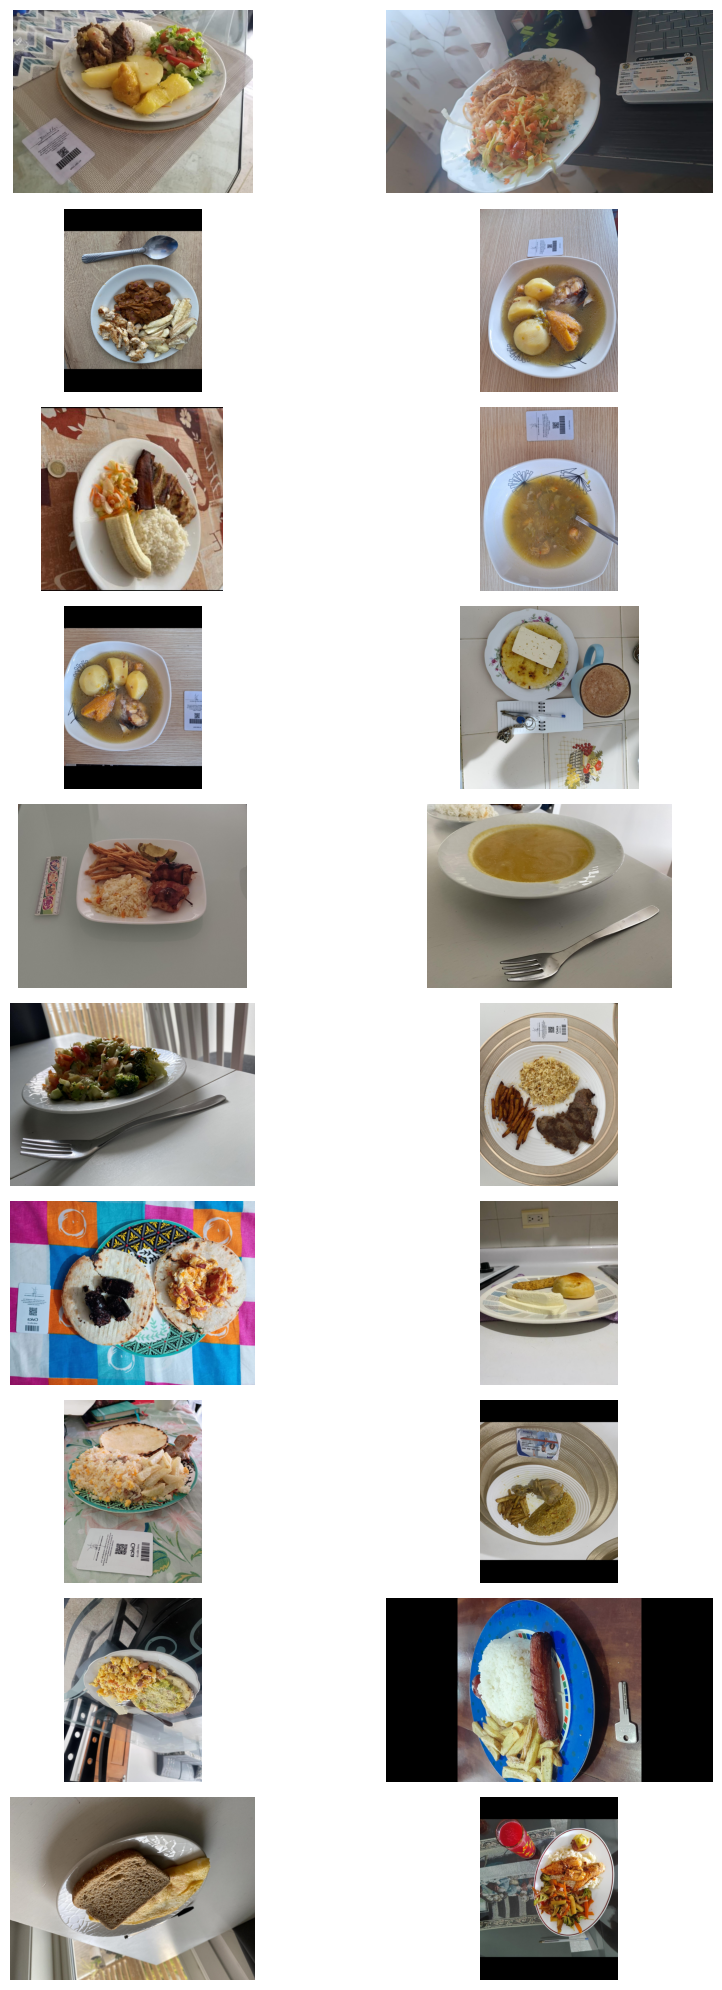

Total de imágenes en toda la carpeta: 1372


In [ ]:
# Obtener lista de archivos de imagen en la carpeta training_path
lista_archivos_training = os.listdir(training_path)
archivos_de_imagen_training = [archivo for archivo in lista_archivos_training if archivo.lower().endswith((".png", ".jpg", ".jpeg"))]

# Obtener lista de archivos de imagen en la carpeta validation_path
lista_archivos_validation = os.listdir(validation_path)
archivos_de_imagen_validation = [archivo for archivo in lista_archivos_validation if archivo.lower().endswith((".png", ".jpg", ".jpeg"))]

# Obtener lista de archivos de imagen en la carpeta testing_path
lista_archivos_testing = os.listdir(testing_path)
archivos_de_imagen_testing = [archivo for archivo in lista_archivos_testing if archivo.lower().endswith((".png", ".jpg", ".jpeg"))]

# Sumar cantidad de archivos de imagen en cada carpeta
total_archivos_training = len(archivos_de_imagen_training)
total_archivos_validation = len(archivos_de_imagen_validation)
total_archivos_testing = len(archivos_de_imagen_testing)

# Contar la cantidad total de imágenes por formato en toda la carpeta
contador_formato_total = defaultdict(int)

for archivo in archivos_de_imagen_training:
    formato = archivo.split(".")[-1].lower()
    contador_formato_total[formato] += 1

# Imprimir la cantidad total de imágenes por formato en toda la carpeta
print("Cantidad total de imágenes por formato en la carpeta Training:")

for formato, cantidad in contador_formato_total.items():
    print(f"Formato {formato}: {cantidad}")

# Seleccionar 20 imagenes random
random_images = random.sample(archivos_de_imagen_training, 20)

# Crea una figura con 10 filas y 2 columnas para mostrar las imágenes
fig, axs = plt.subplots(10, 2, figsize=(10, 20))

# Modifica la matriz de ejes para iterar sobre ella.
axs = axs.flatten()

# Itera sobre las imagenes y las grafica
for i, image_name in enumerate(random_images):
    image_path = os.path.join(training_path, image_name)
    image = skimage.io.imread(image_path)
    axs[i].imshow(image)
    axs[i].axis("off")

# Ajusta el diseño y espaciado del gráfico
plt.tight_layout()

# Muestra la imagen
plt.show()

# Imprimir el total de imágenes en toda la carpeta
total_imagenes = total_archivos_training + total_archivos_validation + total_archivos_testing
print(f"Total de imágenes en toda la carpeta: {total_imagenes}")

**ANALITICA DESCRIPTIVA DE LAS CLASES**.


+---------------+------------+
| Clase         |   Cantidad |
+===============+============+
| arroz         |        749 |
+---------------+------------+
| tag 4         |        688 |
+---------------+------------+
| tag3          |        391 |
+---------------+------------+
| platano       |        358 |
+---------------+------------+
| papa comun    |        290 |
+---------------+------------+
| papas fritas  |        216 |
+---------------+------------+
| arepa paisa   |        125 |
+---------------+------------+
| tag 6         |        122 |
+---------------+------------+
| arepamaiz     |        119 |
+---------------+------------+
| arepapequena  |        102 |
+---------------+------------+
| pan tajado    |         86 |
+---------------+------------+
| frijoles      |         76 |
+---------------+------------+
| tag 7         |         72 |
+---------------+------------+
| yuca          |         71 |
+---------------+------------+
| lentejas      |         57 |
+-------

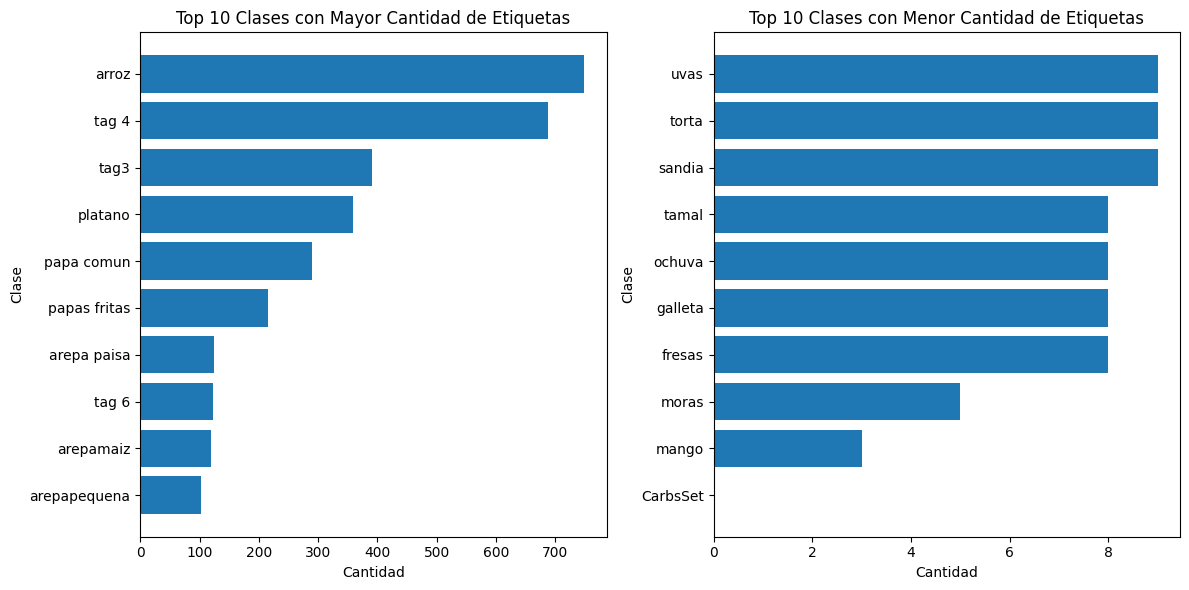

In [ ]:
# Ruta de archivo .coco
file_path = os.path.join(RUTA_PPAL, "DatasetModelCarbs/_annotations.coco.json")

# Leer archivo en ruta especificada
with open(file_path, "r") as file:
    data = json.load(file)

# Crear un diccionario para contar las etiquetas y su respectiva cantidad
label_counts = {}
for category in data["categories"]:
    label_counts[category["name"]] = 0

# Contar la cantidad de etiquetas en el archivo
for annotation in data["annotations"]:
    label_counts[data["categories"][annotation["category_id"]]["name"]] += 1

# Ordenar las etiquetas por cantidad descendente
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Crear una tabla con las etiquetas y su cantidad
table = []
for label, count in sorted_labels:
    table.append([label, count])

# Imprimir la tabla de etiquetas y su cantidad
print(tabulate(table, headers=["Clase", "Cantidad"], tablefmt="grid"))

average_labels = sum(label_counts.values()) / len(label_counts)
print(f"Promedio de número de etiquetas por clase: {average_labels}")

# Mostrar top 5 clases con menos etiquetas
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1])
print("Top 5, clases con menos etiquetas:")

for label, count in sorted_labels[:5]:
    print(f"Clase: {label}, Cantidad: {count}")

# Calcula el número de clases en el archivo
total_classes = len(data["categories"])

# Imprimir el número total de clases
print(f"Numero total de clases: {total_classes}")

# Crea lista de nombres de clases
class_names = [category["name"] for category in data["categories"]]

# Cantidad por clase
class_counts = [label_counts[class_name] for class_name in class_names]

# Obtener las 10 clases con menor cantidad de etiquetas
top_10_classes = sorted_labels[-10:]
top_10_class_names = [label for label, _ in top_10_classes]
top_10_class_counts = [count for _, count in top_10_classes]

# Obtener las 10 clases con menor cantidad de etiquetas
bottom_10_classes = sorted_labels[:10]
bottom_10_class_names = [label for label, _ in bottom_10_classes]
bottom_10_class_counts = [count for _, count in bottom_10_classes]

# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar las 10 clases con mayor cantidad de etiquetas
axs[0].barh(top_10_class_names, top_10_class_counts)
axs[0].set_title("Top 10 Clases con Mayor Cantidad de Etiquetas")
axs[0].set_xlabel("Cantidad")
axs[0].set_ylabel("Clase")

# Graficar las 10 clases con Menor cantidad de etiquetas
axs[1].barh(bottom_10_class_names, bottom_10_class_counts)
axs[1].set_title("Top 10 Clases con Menor Cantidad de Etiquetas")
axs[1].set_xlabel("Cantidad")
axs[1].set_ylabel("Clase")

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


## **Preprocesamiento del banco de imagénes**


Inicialmente se muestra el procesamiento, y después los datos son llevados a una función de python para procesar todo el conjunto de imágenes.

El inicio del proceso implica la definición del tamaño de la imagen (dim). Posteriormente, se procede a cargar la imagen y aplicar una operación de redimensionamiento para estandarizar todas las imágenes en el conjunto.

In [ ]:
# Selecciona un índice aleatorio dentro del rango de las imágenes de entrenamiento
i_random = np.random.randint(0, len(archivos_de_imagen_training))

# Define las dimensiones deseadas para la imagen resultante
dim = (512, 512)

# Carga la imagen correspondiente a la posición i en la lista de imágenes
image_path = os.path.join(training_path, archivos_de_imagen_training[i_random])
image = skimage.io.imread(image_path)

# Imprime la forma (dimensiones) de la imagen cargada
print(f"Dimensiones de la imagen original: {np.shape(image)}")

# Aplica una operación de redimensionamiento a la imagen utilizando las dimensiones definidas
# La interpolación INTER_AREA es utilizada para conservar la información de la imagen al cambiar su tamaño
resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Imprime la forma (dimensiones) de la imagen redimensionada
print(f"Dimensiones de la imagen redimensionada: {np.shape(resized)}")

Dimensiones de la imagen original: (2048, 1536, 3)
Dimensiones de la imagen redimensionada: (512, 512, 3)


**Ecualización de Histograma**

Elegimos al azar una imagen de entrenamiento, la redimensionamos a un tamaño específico, mejoramos su contraste mediante la ecualización del histograma y, finalmente, exhibimos tanto la imagen original como la ecualizada.

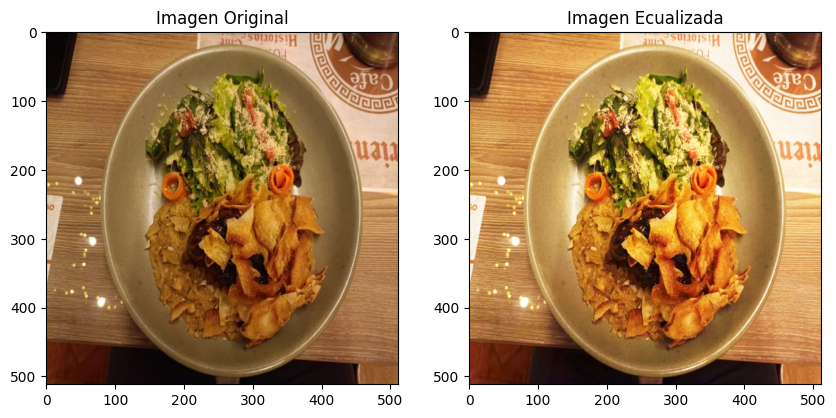

In [ ]:
# Ecualizar el histograma de la imagen
equalized_image = skimage.exposure.equalize_hist(resized)

# Crear una figura para mostrar la imagen original y la imagen ecualizada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(resized, cmap="gray")
axes[0].set_title("Imagen Original")
axes[1].imshow(equalized_image, cmap="gray")
axes[1].set_title("Imagen Ecualizada")

# Mostrar las imágenes
plt.show()

**Corrección Gamma**

A continuación, se transforma una imagen previamente ecualizada a escala de grises y se le aplica una corrección gamma para afinar su brillo y contraste. Luego, ambas versiones, la imagen original en escala de grises y la imagen modificada con corrección gamma, son mostradas en una figura compuesta por dos subtramas para su visualización comparativa.

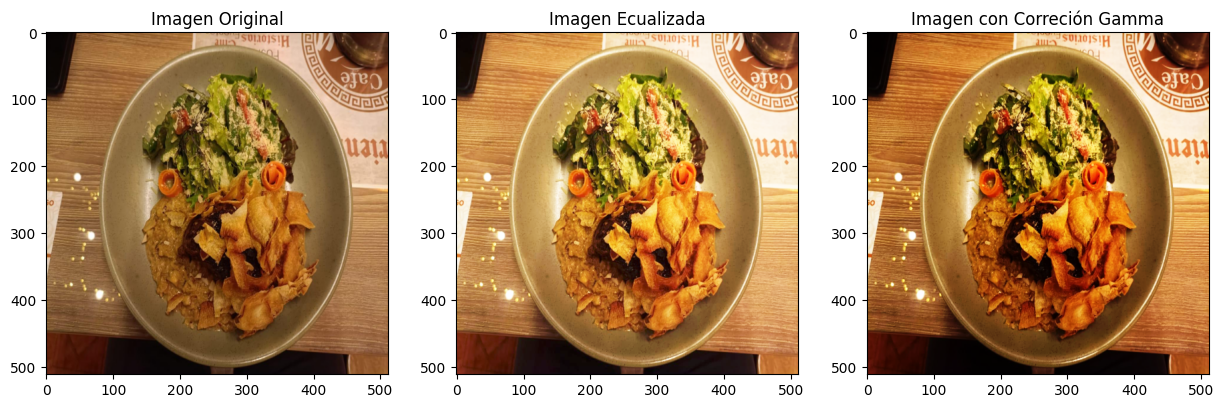

In [ ]:
# Aplicar la corrección gamma a la imagen ecualizada
gamma = 1.5  # Parametro de aumento de contraste
gamma_corrected_image = exposure.adjust_gamma(equalized_image, gamma)

# Crear una figura para mostrar la imagen original, la imagen ecualizada y la imagen corregida con gamma
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar la imagen original en la primera subtrama
axes[0].imshow(resized, cmap="gray")
axes[0].set_title("Imagen Original")

# Mostrar la imagen ecualizada en la segunda subtrama
axes[1].imshow(equalized_image, cmap="gray")
axes[1].set_title("Imagen Ecualizada")

# Mostrar la imagen corregida con gamma en la tercera subtrama
axes[2].imshow(gamma_corrected_image, cmap="gray")
axes[2].set_title("Imagen con Correción Gamma")

# Mostrar las imágenes
plt.show()

Acá observamos el histograma resultante:

(0.0, 1.0)

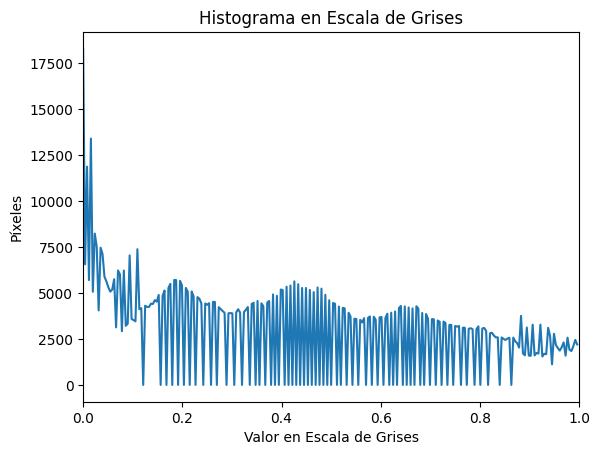

In [ ]:
# Se crea un histograma de la imagen ecualizada con corrección gamma
histogram, bin_edges = np.histogram(gamma_corrected_image, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Histograma en Escala de Grises")
plt.xlabel("Valor en Escala de Grises")
plt.ylabel("Píxeles")
plt.xlim(0, 1.0)

#### **Extracción de características**

Modelo de Segmentación de Bordes de Canny

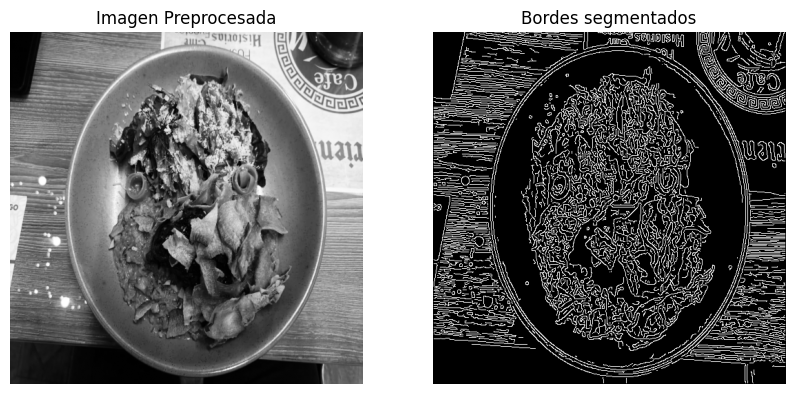

In [ ]:
# Aplica el modelo de segmentación por bordes de Canny
gray_image = rgb2gray(gamma_corrected_image)

edges = canny(gray_image)

# Graficar la imagen preprocesada y los bordes segmentados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gray_image, cmap="gray")
ax[0].set_title("Imagen Preprocesada")
ax[0].axis("off")
ax[1].imshow(edges, cmap="gray")
ax[1].set_title("Bordes segmentados")
ax[1].axis("off")

plt.show()

Obtención de Mascaras

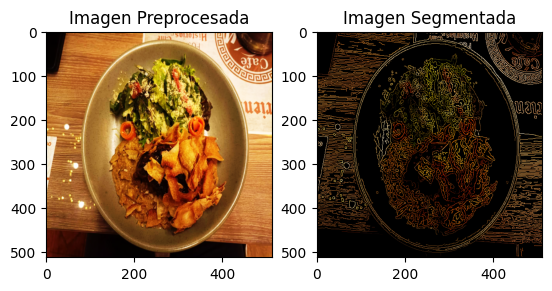

In [ ]:
# Extraer la mascara del modelo segmentado
mask_canny = edges != 0


def mask_aplication(image, binary_mask):
    """
    Aplica la máscara a la imagen preprocesada y la gráfica.
    """
    # Aplica la máscara a la imagen preprocesada
    segmented_image = np.copy(image)
    segmented_image[~binary_mask] = 0

    # Grafica la imagen procesada
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Imagen Preprocesada")

    # Grafica la imagen segmentada
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title("Imagen Segmentada")

    # Mostrar la gráfica
    plt.show()


mask_aplication(gamma_corrected_image, mask_canny)

Por último creamos una máscara, usando la técnica de umbralización Otsu.

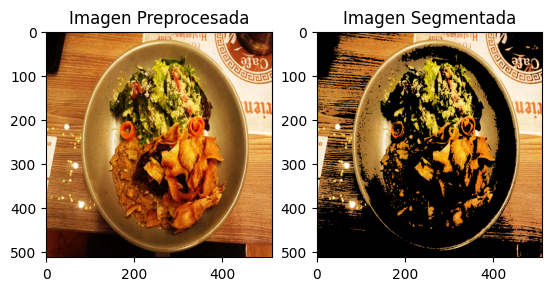

In [ ]:
# Crea la máscara binaria
t = skimage.filters.threshold_otsu(gray_image)
mask_otsu = gray_image > t

mask_aplication(gamma_corrected_image, mask_otsu)

Modelo de Segmentación por clustering de pixeles

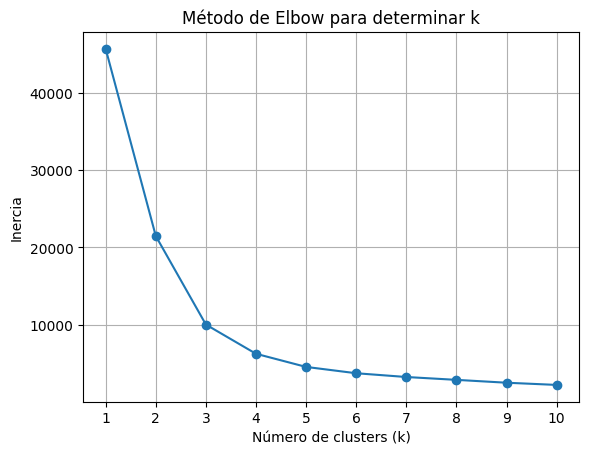

In [ ]:
# Cambiar la forma de la imagen a una matriz 2D
image_2d = gamma_corrected_image.reshape(-1, 3)

# Calcular la inercia para diferentes valores de k
inertia = []
k_values = range(1, 11)  
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(image_2d)
    inertia.append(kmeans.inertia_)

# Graficar el método de Elbow
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método de Elbow para determinar k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

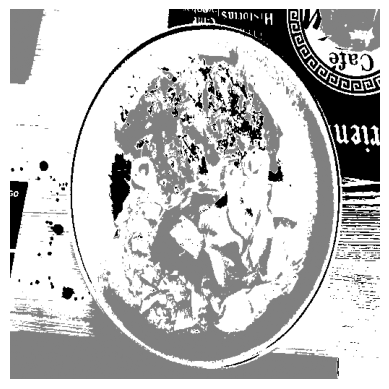

In [ ]:
# Se aplica el Clustering K-means
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(image_2d)

# Se redimenciona los labels a partir del tamaño de la img preprocesada
segmented_image_clustering = labels.reshape(gamma_corrected_image.shape[:2])

# Se muestra la imagen segmentada con el metodo de segmentación k-means
plt.imshow(segmented_image_clustering, cmap="gray")
plt.axis("off")
plt.show()

Se aplica la máscara a la imagén preprocesada

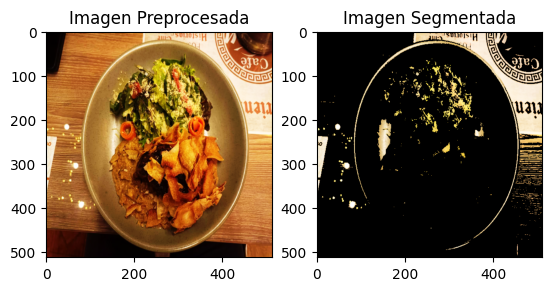

In [ ]:
mask_kmeans = segmented_image_clustering > 0
mask_kmeans = ~mask_kmeans
mask_aplication(gamma_corrected_image, mask_kmeans)

Finalmente, se pone a prueba la segmentación a partir del etiquetado inicial en las imagenes.

In [ ]:
def create_mask(image_info, annotations, coco):
    """
    Crea la máscara de segmentación a partir de las anotaciones del archivo .coco.json
    """
    # Creamos una máscara vacía como un array numpy
    mask_np = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint16)
    classes = [coco.loadCats(ann["category_id"])[0]["name"] for ann in annotations]

    for ann, class_name in zip(annotations, classes):
        if ann["image_id"] == image_info["id"]:
            # Extraemos el polígono de segmentación
            for seg in ann["segmentation"]:
                # Agrupamos los class_ids de las frutas en uno solo
                class_id = ann["category_id"]
                # Convertimos los polígonos en una máscara binaria y la agregamos a la máscara principal
                coordinates = np.array(seg).reshape((-1, 2))
                cv2.fillPoly(mask_np, [coordinates.astype(np.int32)], color=class_id)
    return mask_np, classes

In [ ]:
coco_json_file = os.path.join(RUTA_PPAL, file_path)

# Inicializamos el objeto COCO
coco = COCO(coco_json_file)

# Obtenemos el nombre de archivo de la imagen de prueba
archivo_img = archivos_de_imagen_training[i_random]

# Inicializamos el ID de la imagen como None
img_id = None
# Iteramos sobre todas las imágenes cargadas
for img_iter in coco.dataset["images"]:
    # Verificamos si el nombre de archivo coincide
    if img_iter["file_name"] == archivo_img:
        img_id = img_iter["id"]
        break

# Cargamos la información de la imagen
img_info = coco.loadImgs(img_id)[0]


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


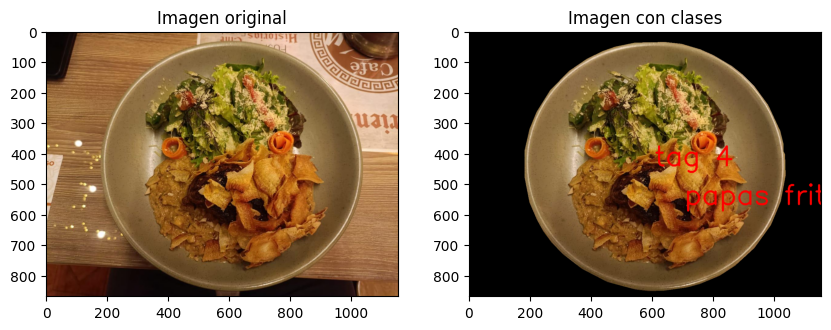

In [ ]:
# Cargamos las anotaciones de la imagen
annIds = coco.getAnnIds(imgIds=img_id)
annotations = coco.loadAnns(annIds)

# Creamos la máscara para la imagen actual
mask_np, classes = create_mask(img_info, annotations, coco)

# Obtenemos las dimensiones de la imagen original
img_height = img_info["height"]
img_width = img_info["width"]

# Creamos una nueva imagen con las mismas dimensiones que la original
imagee = image.copy()
maskk = mask_np > 0

# Aplicamos la máscara a la nueva imagen
imagee[~maskk] = 0

# Creamos una nueva imagen con las mismas dimensiones que la original
image_with_labels = imagee.copy()

# Iteramos sobre cada máscara y su clase correspondiente
for ann, class_name in zip(annotations, classes):
    if class_name:
        mask_coco, _  = create_mask(img_info, [ann], coco)
        mask = mask_coco > 0
        # Calculamos el centroide de la máscara
        centroid = np.mean(np.argwhere(mask), axis=0)
        # Posición para mostrar el nombre de la clase encima de la etiqueta
        text_position = (int(centroid[1]), int(centroid[0]) - 2)
        # Agregamos el nombre de la clase encima de la etiqueta en la imagen
        image_with_labels = cv2.putText(
            image_with_labels,
            class_name,
            text_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            3,
            (255, 0, 0),
            6,
        )

# Se grafican ambas imagénes para ver la diferencia
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Imagen original")
axs[1].imshow(image_with_labels)
axs[1].set_title("Imagen con clases")
plt.show()

#### **Métricas de Segmentación**

Se aplicaron 5 métricas (Precisión, Recall, Accuracy, Dice, IoU) a diferentes modelos, utilizando como imagen real la etiquetada y como imagen predicha la obtenida por cada modelo. Valores cercanos a 1 indican mejor segmentación, mientras que valores cercanos a 0 indican segmentación deficiente.

In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    """
    Calcula la precisión entre dos máscaras binarias.
    Precision mide la proporción de píxeles correctamente detectados como
    verdaderos positivos respecto al total de píxeles predichos como positivos.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect / total_pixel_pred)
    return round(precision, 3)


def recall_score_(groundtruth_mask, pred_mask):
    """
    Calcula el recall entre dos máscaras binarias.
    Recall mide la proporción de píxeles correctamente detectados
    como verdaderos positivos respecto al total de píxeles de verdad.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect / total_pixel_truth)
    return round(recall, 3)


def accuracy(groundtruth_mask, pred_mask):
    """
    Calcula la precisión (accuracy) entre dos máscaras binarias.
    Accuracy mide la proporción de píxeles correctamente clasificados
    (ya sea verdaderos positivos o verdaderos negativos) respecto al total de píxeles.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask == pred_mask)
    acc = np.mean(xor / (union + xor - intersect))
    return round(acc, 3)


def dice_coef(groundtruth_mask, pred_mask):
    """
    Calcula el coeficiente de Dice entre dos máscaras binarias.
    El coeficiente de Dice es una medida de similitud que
    compara el área de superposición entre las máscaras con el
    área total de ambas máscaras.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2 * intersect / total_sum)
    return round(dice, 3)


def iou(groundtruth_mask, pred_mask):
    """
    Calcula el índice de Jaccard (IoU) entre dos máscaras binarias.
    IoU mide la superposición entre dos máscaras como el
    área de intersección dividido por el área de unión.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect / union)
    return round(iou, 3)

maskk = transform.resize(maskk, dim, mode='constant', order=0)
# Calcular métricas para todas las máscaras
metrics_table = {
    "Máscara": ["Canny", "Otsu", "K-means"],
    "Precisión": [
        precision_score_(maskk, mask_canny),
        precision_score_(maskk, mask_otsu),
        precision_score_(maskk, mask_kmeans),
    ],
    "Recall": [
        recall_score_(maskk, mask_canny),
        recall_score_(maskk, mask_otsu),
        recall_score_(maskk, mask_kmeans),
    ],
    "Accuracy": [
        accuracy(maskk, mask_canny),
        accuracy(maskk, mask_otsu),
        accuracy(maskk, mask_kmeans),
    ],
    "Dice Coefficient": [
        dice_coef(maskk, mask_canny),
        dice_coef(maskk, mask_otsu),
        dice_coef(maskk, mask_kmeans),
    ],
    "IoU": [iou(maskk, mask_canny), iou(maskk, mask_otsu), iou(maskk, mask_kmeans)],
}

# Imprimir la tabla de métricas
print("Tabla de Métricas:")
for key, values in metrics_table.items():
    print(key + ":", values)

Tabla de Métricas:
Máscara: ['Canny', 'Otsu', 'K-means']
Precisión: [np.float64(0.526), np.float64(0.476), np.float64(0.316)]
Recall: [np.float64(0.164), np.float64(0.428), np.float64(0.072)]
Accuracy: [np.float64(0.462), np.float64(0.43), np.float64(0.408)]
Dice Coefficient: [np.float64(0.25), np.float64(0.451), np.float64(0.117)]
IoU: [np.float64(0.143), np.float64(0.291), np.float64(0.062)]


#### **Preprocesamiento general**

Se encapsuló el preprocesamiento en la función preprocessing(), que devuelve el tensor listo para el modelo. No se aplicaron ecualización de histograma ni corrección gamma, ya que el preprocessor oficial de PyTorch define las transformaciones óptimas (como resize y normalización con estadísticas de ImageNet). Incluir ajustes extra alteraría estas estadísticas y afectaría el rendimiento del modelo, debido a la pérdida de información.

In [ ]:
def preprocess_images(ruta_folder, file_name):
    """
    Aplica el preprocesamiento a las imágenes y las máscaras.
    Carga de Imagen - Redimensionamiento
    """
    # Se crea la ruta para la imagen actual
    image_path = os.path.join(ruta_folder, file_name)

    # Cargar la imagen
    if image_path.endswith((".png", ".jpg", ".jpeg")):
        imagee = cv2.imread(image_path, cv2.IMREAD_COLOR)
    else:
        raise ValueError(f"Formato de archivo no soportado: {image_path}")

    # Aplicar redimensionamiento a la imagen
    dim = (512, 512)
    resized = cv2.resize(imagee, dim)

    return resized

In [144]:
def get_mask(file_name, coco):
    """
    Obtiene la máscara a partir del archivo de la imagén y el archivo .coco.json
    return (Ancho, Alto)
    """
    # Inicializar el ID de la imagen como None
    img_id = None
    # Iterar sobre todas las imágenes cargadas
    for img_iter in coco.dataset["images"]:
        # Verificar si el nombre de archivo coincide
        if img_iter["file_name"] == file_name:
            img_id = img_iter["id"]
            break

    # Cargar la información de la imagen
    img_info = coco.loadImgs(img_id)[0]

    # Cargar las anotaciones de la imagenc
    annIds = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(annIds)

    # Creamos la máscara para la imagen actual
    mask_np, _ = create_mask(img_info, annotations, coco)
    return mask_np

In [ ]:
def visualize_mask(mask):
    plt.imshow(mask)
    plt.colorbar()
    plt.title("Máscara Base")
    plt.show()

Sanity Check Pre-Processing

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


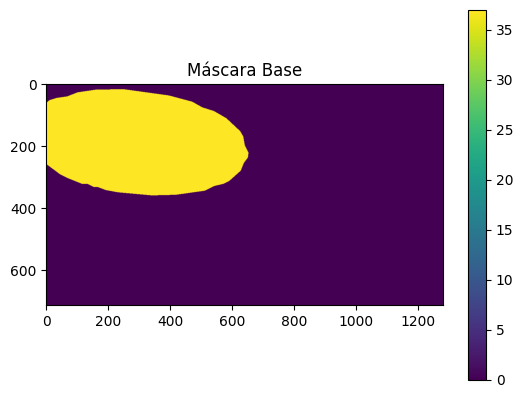

In [ ]:
file_name = archivos_de_imagen_training[i_random]
coco_json_file = os.path.join(RUTA_PPAL, file_path)
coco = COCO(coco_json_file)
mask_np = get_mask(file_name, coco)
visualize_mask(mask_np)

# Estructura de Carpetas para entrenar el modelo
- **Carbs_cuant_mhealth/**
    - **MODEL_CARBS.ipynb**: Este es el cuaderno de Jupyter para entrenar el modelo.
    - **Dataset/**
        - **train/**: Carpeta que contiene las imágenes de entrenamiento.
        - **test/**: Carpeta que contiene las imágenes de prueba.
        - **validation/**: Carpeta que contiene las imágenes de validación.
        - **_annotations.coco.json**: Archivo JSON que contiene las anotaciones en formato COCO.
    - **Drive/**



**Tipo de problema de analítica:**  Segmentación semántica.
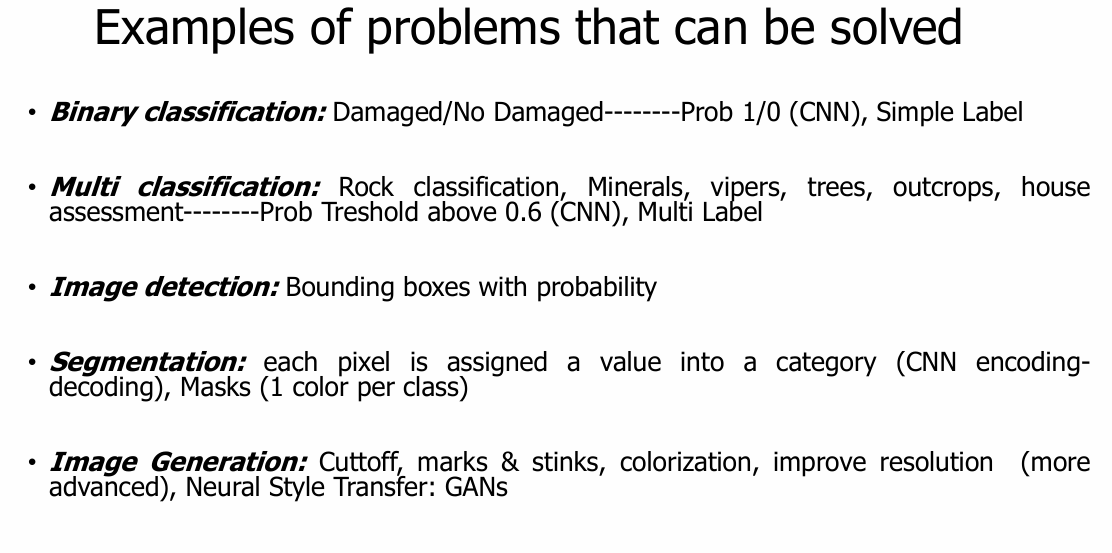

# **📌 Modelo: UperNet con ConvNeXt Backbone (Hugging Face)**

## **Descripción**
UperNet (**Unified Perceptual Parsing Network**) es un modelo avanzado de segmentación semántica que usa una estructura jerárquica basada en **Feature Pyramid Network (FPN)**.  
Este modelo combina un **backbone ConvNeXt** con un **decoder UperNet**, lo que permite segmentar imágenes con alta precisión.  
ConvNeXt es una mejora de CNNs tradicionales, optimizada con ideas de Transformers.

---

## **Arquitectura del Modelo**
El modelo **UperNet con ConvNeXt** tiene **dos componentes principales**:

 **Backbone: ConvNeXt** → Extrae características de múltiples niveles  
 **Decoder: UperNet** → Genera el mapa de segmentación  

---

## **Backbone: ConvNeXt**
ConvNeXt es un backbone convolucional moderno optimizado para visión computacional.  
**Mejora ResNet** con técnicas de Transformers para una mejor extracción de características.

### **Características del Backbone ConvNeXt**
- **Embeddings Iniciales:** Convierte la imagen en representaciones con `patch size=4x4`.
- **Módulos ConvNeXt:** Aplica convoluciones profundas optimizadas con activación `GELU`.
- **Downsampling Jerárquico:** Usa convoluciones `stride=2` en múltiples etapas.

**Pipeline Backbone ConvNeXt**:
Entrada → Conv Patch 4x4 → Bloques ConvNeXt → Downsampling → Más Bloques ConvNeXt → Salida

---

## **Decoder de Segmentación: UperNet**
El decoder UperNet usa una **Feature Pyramid Network (FPN)** combinada con un **Pyramid Pooling Module (PSP)**.  
Esto permite **fusionar información de múltiples niveles** para generar mapas de segmentación precisos.

### **Componentes del Decoder UperNet**
- **PSP Module:** Extrae información de múltiples escalas con `AdaptiveAvgPooling`.
- **FPN Convs:** Convierte características de la FPN en mapas segmentados.
- **Clasificador Final:** Usa una convolución `1x1` para mapear las features a clases.

**Pipeline del Decoder UperNet**:

Feature Maps de ConvNeXt → Pyramid Pooling → Fusion de Features → Segmentación Final

# Definición de la función de pérdida, optimizador y demás elementos del pipeline para construir la segmentación a partir de un modelo preentrenado

Exposición del dispositivo cuda

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Función de pérdida

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha  # Tensor de pesos [num_classes]
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = inputs.float()
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        loss = (1 - pt) ** self.gamma * ce_loss
        return loss.mean()


criterion = FocalLoss(alpha=None).to(device)


Sanity Check (Función de pérdida)

In [ ]:
inputs = torch.randn(2, 49, 128, 128).to(device)
targets = torch.randint(0, 49, (2, 128, 128)).to(device)

criterion(inputs, targets)

tensor(4.2389, device='cuda:0')

Construcción del Dataloader

In [ ]:
class FoodSegDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root: str,
        image_files: list[str],
        coco_path: str,
        processor,
        target_size: tuple[int, int] = (512, 512),
        ignore_suffix: tuple[str, ...] = ("(1).jpg", "(2).jpg", "(3).jpg", "(4).jpg"), # Exclusión de duplicados por error
    ):
        self.root = root
        self.coco = COCO(coco_path)
        self.processor = processor
        self.target_size = target_size


        self.image_files = [
            f for f in image_files if not f.endswith(ignore_suffix)
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]

        # ---- IMAGEN ----
        img_path = os.path.join(self.root, fname)
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.processor(img, return_tensors="pt").pixel_values.squeeze(0)

        # ---- MASCÁRA ----
        mask = get_mask(fname, self.coco)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
        mask_tensor = torch.as_tensor(mask, dtype=torch.long)

        return img_tensor, mask_tensor


Procesador de la Red usando el API de hugging face

In [ ]:
processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
train_ds = FoodSegDataset(training_path, archivos_de_imagen_training, coco_json_file, processor)
val_ds   = FoodSegDataset(validation_path, archivos_de_imagen_validation, coco_json_file, processor)
test_ds  = FoodSegDataset(testing_path,  archivos_de_imagen_testing,  coco_json_file, processor)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


Ponderación de clases y remuestreo en el dataset, para disminuir desbalance.

In [ ]:
def build_sampler(dataset, num_clases, dominante=True, eps=1e-6):
    """
    Calcula pesos por imagen y devuelve un WeightedRandomSampler.
    """
    counts = torch.zeros(num_clases, dtype=torch.long)
    dom_clases = torch.empty(len(dataset), dtype=torch.long)

    for idx in range(len(dataset)):
        _, mask = dataset[idx]

        binc = torch.bincount(mask.flatten(), minlength=num_clases)
        counts += binc

        if dominante:
            dom_clases[idx] = torch.argmax(binc)
        else:
            dom_clases[idx] = -1


    class_weights = 1.0 / (counts.float() + eps)

    if dominante:
        sample_weights = class_weights[dom_clases]
    else:
        sample_weights = torch.empty(len(dataset))
        for idx in range(len(dataset)):
            _, mask = dataset[idx]
            sample_weights[idx] = class_weights[mask].mean()

    return WeightedRandomSampler(sample_weights,
                                 num_samples=len(sample_weights),
                                 replacement=True)


In [ ]:
N_CLASSES = 49

train_sampler = build_sampler(train_ds, N_CLASSES)
val_sampler   = None
test_sampler  = None

train_loader = DataLoader(train_ds, batch_size=4, sampler=train_sampler,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False,
                          num_workers=4, pin_memory=True)


In [ ]:
class_ids = set()

for _, labels  in train_loader:
    masks = labels
    for mask in masks:
        class_ids.update(torch.unique(mask).tolist())

class_ids = sorted(list(class_ids))
custom_id2label = {i: f"class_{i}" for i in class_ids}
custom_label2id = {v: k for k, v in custom_id2label.items()}

print("id2label:", custom_id2label)
print("label2id:", custom_label2id)

num_labels = len(custom_id2label)

id2label: {0: 'class_0', 1: 'class_1', 2: 'class_2', 4: 'class_4', 5: 'class_5', 6: 'class_6', 7: 'class_7', 8: 'class_8', 10: 'class_10', 12: 'class_12', 13: 'class_13', 14: 'class_14', 15: 'class_15', 16: 'class_16', 17: 'class_17', 18: 'class_18', 19: 'class_19', 20: 'class_20', 21: 'class_21', 22: 'class_22', 23: 'class_23', 24: 'class_24', 25: 'class_25', 26: 'class_26', 27: 'class_27', 28: 'class_28', 29: 'class_29', 31: 'class_31', 32: 'class_32', 34: 'class_34', 35: 'class_35', 37: 'class_37', 38: 'class_38', 39: 'class_39', 40: 'class_40', 41: 'class_41', 42: 'class_42', 43: 'class_43', 46: 'class_46', 47: 'class_47', 48: 'class_48'}
label2id: {'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_10': 10, 'class_12': 12, 'class_13': 13, 'class_14': 14, 'class_15': 15, 'class_16': 16, 'class_17': 17, 'class_18': 18, 'class_19': 19, 'class_20': 20, 'class_21': 21, 'class_22': 22, 'class_23': 23, 'class_24': 24, 'c

In [ ]:
model = UperNetForSemanticSegmentation.from_pretrained("LightDestory/upernetconvnext-finetuned-segments-food-oct-14")

config.json:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/327M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

In [ ]:
train_loader_iter = iter(train_loader)

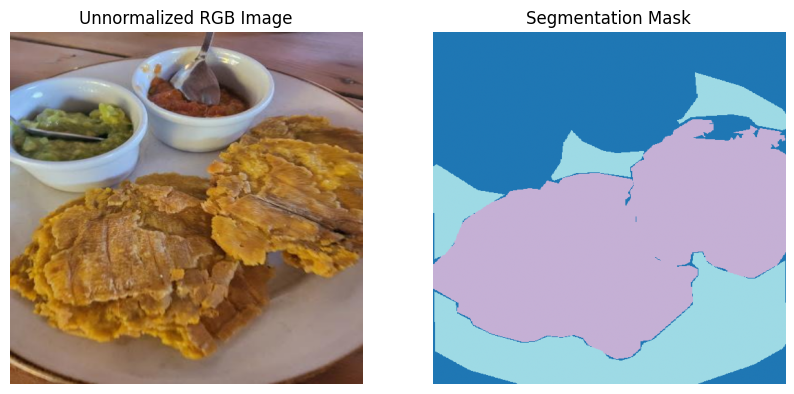

In [ ]:
images, labels = next(train_loader_iter)

def unnormalize(img_tensor):
    """
    Desnormaliza el tensor img para graficar la imagén resultante.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(img_tensor.device)
    img_tensor = img_tensor * std + mean
    img_tensor = img_tensor.clamp(0, 1)
    return img_tensor

image_rgb = images[0]
mask = labels[0].cpu().numpy()

image_rgb = unnormalize(image_rgb)
image_rgb = image_rgb.cpu().permute(1, 2, 0).numpy()
image_rgb = (image_rgb * 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Unnormalized RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="tab20")
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()



In [ ]:
print("Valores únicos en las etiquetas:", torch.unique(labels))
print("Valor máximo en las etiquetas:", torch.max(labels))
print("Valor mínimo en las etiquetas:", torch.min(labels))

Valores únicos en las etiquetas: tensor([ 0,  6, 18, 34, 37, 48])
Valor máximo en las etiquetas: tensor(48)
Valor mínimo en las etiquetas: tensor(0)


In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)
scaler = torch.GradScaler("cuda")

In [ ]:
for images, masks in train_loader:
    print(f"Forma de las imágenes en un lote: {images.shape}")
    print(f"Forma de las máscaras en un lote: {masks.shape}")
    break

Forma de las imágenes en un lote: torch.Size([4, 3, 512, 512])
Forma de las máscaras en un lote: torch.Size([4, 512, 512])


In [ ]:
print(f"Memoria total reservada por PyTorch: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
print(f"Memoria actualmente asignada: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Memoria máxima usada: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

Memoria total reservada por PyTorch: 0.02 GB
Memoria actualmente asignada: 0.01 GB
Memoria máxima usada: 0.01 GB


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def pixel_accuracy(output, mask):
    """
    Calcula la precisión por máscara predicha.
    """
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=total_classes):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    best_miou = 0
    patience = 10
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        model.train()
        for i, data in enumerate(tqdm(train_loader)):

            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device).squeeze(-1).long();
            #forward
            output = model(image)
            loss = criterion(output.logits, mask)

            iou_score += mIoU(output.logits, mask)
            accuracy += pixel_accuracy(output.logits, mask)
            #backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            lrs.append(get_lr(optimizer))

            running_loss += loss.item()
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask = mask_tiles.to(device).squeeze(-1).long();
                    output = model(image)

                    val_iou_score +=  mIoU(output.logits, mask)
                    test_accuracy += pixel_accuracy(output.logits, mask)

                    loss = criterion(output.logits, mask)
                    test_loss += loss.item()


            val_miou_epoch = val_iou_score / len(val_loader)
            train_miou_epoch = iou_score / len(train_loader)

            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            val_iou.append(val_miou_epoch)
            train_iou.append(train_miou_epoch)
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))

            if val_miou_epoch > best_miou:
                print('mIoU Improving.. {:.3f} >> {:.3f}'.format(best_miou, val_miou_epoch))
                best_miou = val_miou_epoch
                not_improve = 0
                if best_miou > 0.40:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(best_miou))
            else:
                not_improve += 1
                print(f'mIoU did not improve for {not_improve} epoch(s)')
                if not_improve >= patience:
                    print(f'mIoU did not improve for {patience} epochs — stopping training.')
                    break

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
            scheduler.step(test_loss / len(val_loader))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Ejecutar entrenamiento

In [ ]:
epoch = 40
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler)

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.000 >> 0.272
Epoch:1/40.. Train Loss: 0.276.. Val Loss: 0.502.. Train mIoU:0.621.. Val mIoU: 0.272.. Train Acc:0.889.. Val Acc:0.805.. Time: 2.03m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.272 >> 0.330
Epoch:2/40.. Train Loss: 0.148.. Val Loss: 0.384.. Train mIoU:0.699.. Val mIoU: 0.330.. Train Acc:0.928.. Val Acc:0.836.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.330 >> 0.336
Epoch:3/40.. Train Loss: 0.114.. Val Loss: 0.336.. Train mIoU:0.737.. Val mIoU: 0.336.. Train Acc:0.941.. Val Acc:0.830.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.336 >> 0.362
Epoch:4/40.. Train Loss: 0.101.. Val Loss: 0.315.. Train mIoU:0.750.. Val mIoU: 0.362.. Train Acc:0.942.. Val Acc:0.829.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:5/40.. Train Loss: 0.085.. Val Loss: 0.354.. Train mIoU:0.779.. Val mIoU: 0.337.. Train Acc:0.949.. Val Acc:0.812.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.362 >> 0.400
saving model...
Epoch:6/40.. Train Loss: 0.111.. Val Loss: 0.326.. Train mIoU:0.747.. Val mIoU: 0.400.. Train Acc:0.939.. Val Acc:0.816.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.400 >> 0.470
saving model...
Epoch:7/40.. Train Loss: 0.082.. Val Loss: 0.227.. Train mIoU:0.778.. Val mIoU: 0.470.. Train Acc:0.954.. Val Acc:0.876.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:8/40.. Train Loss: 0.056.. Val Loss: 0.276.. Train mIoU:0.829.. Val mIoU: 0.467.. Train Acc:0.963.. Val Acc:0.853.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.470 >> 0.501
saving model...
Epoch:9/40.. Train Loss: 0.065.. Val Loss: 0.206.. Train mIoU:0.816.. Val mIoU: 0.501.. Train Acc:0.961.. Val Acc:0.883.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:10/40.. Train Loss: 0.055.. Val Loss: 0.228.. Train mIoU:0.840.. Val mIoU: 0.452.. Train Acc:0.964.. Val Acc:0.871.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 2 epoch(s)
Epoch:11/40.. Train Loss: 0.049.. Val Loss: 0.251.. Train mIoU:0.847.. Val mIoU: 0.389.. Train Acc:0.968.. Val Acc:0.861.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 3 epoch(s)
Epoch:12/40.. Train Loss: 0.050.. Val Loss: 0.212.. Train mIoU:0.846.. Val mIoU: 0.469.. Train Acc:0.965.. Val Acc:0.870.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.501 >> 0.568
saving model...
Epoch:13/40.. Train Loss: 0.038.. Val Loss: 0.162.. Train mIoU:0.863.. Val mIoU: 0.568.. Train Acc:0.974.. Val Acc:0.899.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.568 >> 0.579
saving model...
Epoch:14/40.. Train Loss: 0.035.. Val Loss: 0.168.. Train mIoU:0.875.. Val mIoU: 0.579.. Train Acc:0.975.. Val Acc:0.901.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:15/40.. Train Loss: 0.043.. Val Loss: 0.175.. Train mIoU:0.863.. Val mIoU: 0.535.. Train Acc:0.968.. Val Acc:0.889.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 2 epoch(s)
Epoch:16/40.. Train Loss: 0.033.. Val Loss: 0.153.. Train mIoU:0.884.. Val mIoU: 0.557.. Train Acc:0.975.. Val Acc:0.898.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 3 epoch(s)
Epoch:17/40.. Train Loss: 0.042.. Val Loss: 0.327.. Train mIoU:0.876.. Val mIoU: 0.390.. Train Acc:0.972.. Val Acc:0.848.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 4 epoch(s)
Epoch:18/40.. Train Loss: 0.055.. Val Loss: 0.221.. Train mIoU:0.846.. Val mIoU: 0.522.. Train Acc:0.964.. Val Acc:0.872.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 5 epoch(s)
Epoch:19/40.. Train Loss: 0.036.. Val Loss: 0.160.. Train mIoU:0.870.. Val mIoU: 0.557.. Train Acc:0.973.. Val Acc:0.901.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 6 epoch(s)
Epoch:20/40.. Train Loss: 0.037.. Val Loss: 0.165.. Train mIoU:0.861.. Val mIoU: 0.561.. Train Acc:0.970.. Val Acc:0.894.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.579 >> 0.660
saving model...
Epoch:21/40.. Train Loss: 0.019.. Val Loss: 0.098.. Train mIoU:0.906.. Val mIoU: 0.660.. Train Acc:0.984.. Val Acc:0.931.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.660 >> 0.695
saving model...
Epoch:22/40.. Train Loss: 0.015.. Val Loss: 0.083.. Train mIoU:0.920.. Val mIoU: 0.695.. Train Acc:0.986.. Val Acc:0.935.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.695 >> 0.699
saving model...
Epoch:23/40.. Train Loss: 0.014.. Val Loss: 0.085.. Train mIoU:0.927.. Val mIoU: 0.699.. Train Acc:0.986.. Val Acc:0.936.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.699 >> 0.713
saving model...
Epoch:24/40.. Train Loss: 0.011.. Val Loss: 0.081.. Train mIoU:0.942.. Val mIoU: 0.713.. Train Acc:0.989.. Val Acc:0.941.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:25/40.. Train Loss: 0.009.. Val Loss: 0.098.. Train mIoU:0.947.. Val mIoU: 0.705.. Train Acc:0.991.. Val Acc:0.930.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.713 >> 0.724
saving model...
Epoch:26/40.. Train Loss: 0.007.. Val Loss: 0.078.. Train mIoU:0.954.. Val mIoU: 0.724.. Train Acc:0.993.. Val Acc:0.945.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.724 >> 0.733
saving model...
Epoch:27/40.. Train Loss: 0.007.. Val Loss: 0.076.. Train mIoU:0.959.. Val mIoU: 0.733.. Train Acc:0.992.. Val Acc:0.948.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:28/40.. Train Loss: 0.006.. Val Loss: 0.102.. Train mIoU:0.959.. Val mIoU: 0.694.. Train Acc:0.992.. Val Acc:0.932.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 2 epoch(s)
Epoch:29/40.. Train Loss: 0.006.. Val Loss: 0.079.. Train mIoU:0.961.. Val mIoU: 0.723.. Train Acc:0.992.. Val Acc:0.947.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 3 epoch(s)
Epoch:30/40.. Train Loss: 0.008.. Val Loss: 0.084.. Train mIoU:0.951.. Val mIoU: 0.727.. Train Acc:0.991.. Val Acc:0.942.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.733 >> 0.738
saving model...
Epoch:31/40.. Train Loss: 0.006.. Val Loss: 0.080.. Train mIoU:0.955.. Val mIoU: 0.738.. Train Acc:0.993.. Val Acc:0.946.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.738 >> 0.738
saving model...
Epoch:32/40.. Train Loss: 0.006.. Val Loss: 0.079.. Train mIoU:0.956.. Val mIoU: 0.738.. Train Acc:0.994.. Val Acc:0.949.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:33/40.. Train Loss: 0.005.. Val Loss: 0.078.. Train mIoU:0.970.. Val mIoU: 0.733.. Train Acc:0.994.. Val Acc:0.946.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 2 epoch(s)
Epoch:34/40.. Train Loss: 0.004.. Val Loss: 0.077.. Train mIoU:0.965.. Val mIoU: 0.738.. Train Acc:0.995.. Val Acc:0.947.. Time: 0.91m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.738 >> 0.741
saving model...
Epoch:35/40.. Train Loss: 0.004.. Val Loss: 0.075.. Train mIoU:0.969.. Val mIoU: 0.741.. Train Acc:0.995.. Val Acc:0.951.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.741 >> 0.742
saving model...
Epoch:36/40.. Train Loss: 0.004.. Val Loss: 0.077.. Train mIoU:0.969.. Val mIoU: 0.742.. Train Acc:0.995.. Val Acc:0.951.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.742 >> 0.745
saving model...
Epoch:37/40.. Train Loss: 0.004.. Val Loss: 0.078.. Train mIoU:0.967.. Val mIoU: 0.745.. Train Acc:0.995.. Val Acc:0.952.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.745 >> 0.749
saving model...
Epoch:38/40.. Train Loss: 0.004.. Val Loss: 0.076.. Train mIoU:0.970.. Val mIoU: 0.749.. Train Acc:0.995.. Val Acc:0.953.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU Improving.. 0.749 >> 0.758
saving model...
Epoch:39/40.. Train Loss: 0.004.. Val Loss: 0.077.. Train mIoU:0.972.. Val mIoU: 0.758.. Train Acc:0.995.. Val Acc:0.953.. Time: 0.92m


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

mIoU did not improve for 1 epoch(s)
Epoch:40/40.. Train Loss: 0.004.. Val Loss: 0.077.. Train mIoU:0.969.. Val mIoU: 0.757.. Train Acc:0.995.. Val Acc:0.952.. Time: 0.91m
Total time: 37.71 m


In [ ]:
torch.save(model, "UperNet_ConvNeXt_End.pth", pickle_module=dill)
print("Modelo completo guardado.")

Modelo completo guardado.


In [ ]:
add_safe_globals([UperNetForSemanticSegmentation])

In [ ]:
model = torch.load("UperNet_ConvNeXt_End.pth", pickle_module=dill)
model.to(device)
model.eval()
print("Modelo completo cargado y listo para predicciones.")


Modelo completo cargado y listo para predicciones.


# Predicciones

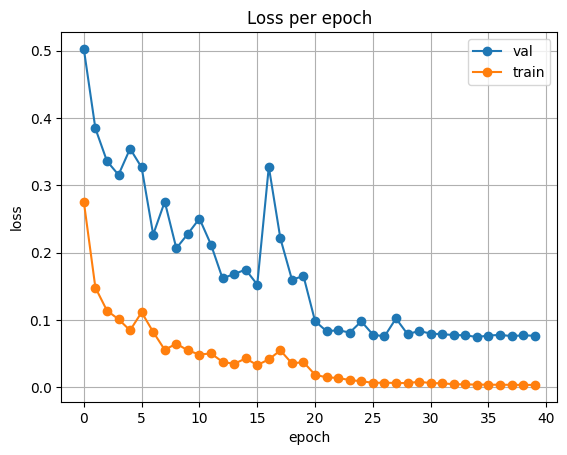

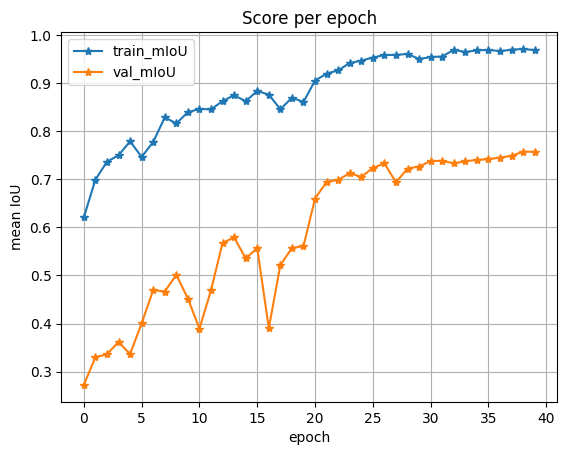

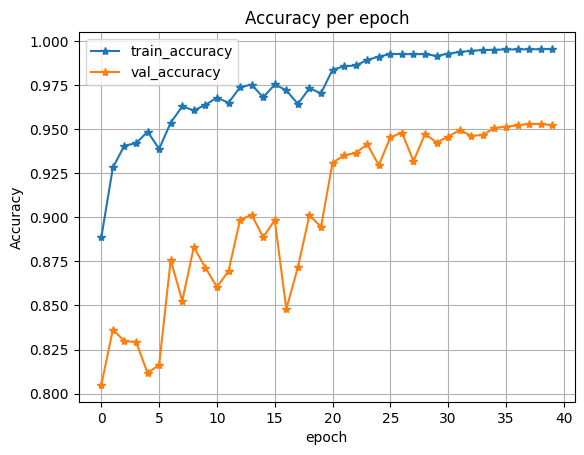

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
model.to(device)
model.eval()

UperNetForSemanticSegmentation(
  (backbone): ConvNextBackbone(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
           

In [ ]:
print(type(model))

<class 'transformers.models.upernet.modeling_upernet.UperNetForSemanticSegmentation'>


In [ ]:
# Verifica si el atributo existe; si no, lo crea
if not hasattr(model.config, "_output_attentions"):
    model.config._output_attentions = False

if not hasattr(model.config, "output_hidden_states"):
    model.config.output_hidden_states = False

if not hasattr(model.config, "return_dict"):
    model.config.return_dict = True


In [ ]:
# Listas para almacenar resultados
predictions = []
ground_truths = []

# Deshabilitar gradientes para ahorrar memoria
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Mover imágenes a GPU o CPU
        labels = labels.to(device)  # Mover etiquetas

        # Hacer la predicción
        outputs = model(inputs)
        if isinstance(outputs, dict):
            logits = outputs["logits"]
        elif hasattr(outputs, "logits"):
            logits = outputs.logits
        else:
            logits = outputs

        # Obtener la clase con mayor probabilidad (argmax en la dimensión de clases)
        preds = torch.argmax(logits, dim=1)

        # Guardar resultados
        predictions.append(preds.cpu())
        ground_truths.append(labels.cpu())

predictions = torch.cat(predictions, dim=0)
ground_truths = torch.cat(ground_truths, dim=0)

In [ ]:
def generate_colormap(num_classes):
    np.random.seed(42)  
    colors = np.random.rand(num_classes, 3)  
    return ListedColormap(colors)

num_classes = len(custom_id2label)
custom_cmap = generate_colormap(num_classes)

In [ ]:
test_loader_iter = iter(test_loader)

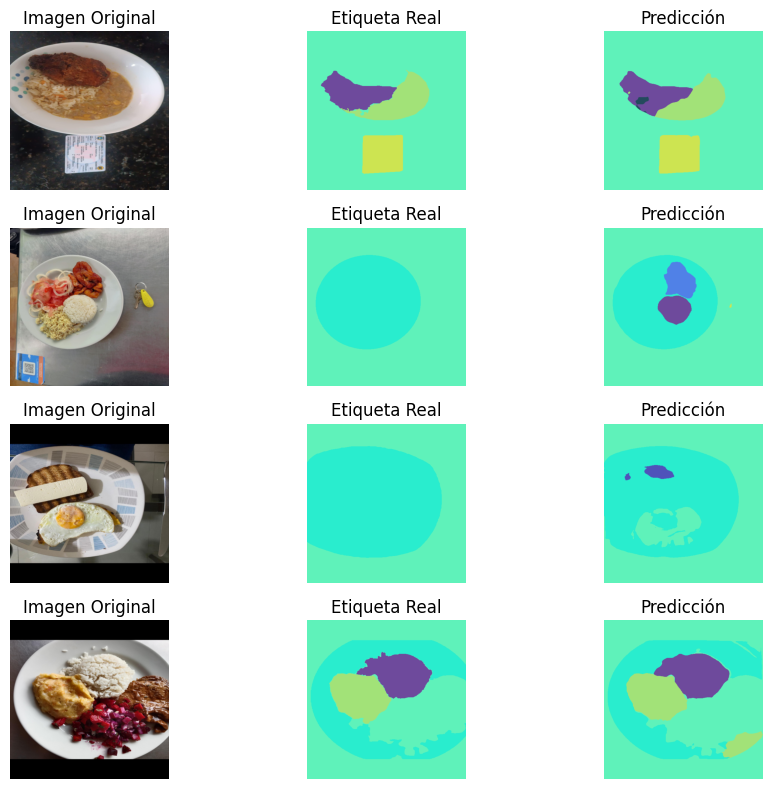

✅ 4 máscaras guardadas en: ./predicted_masks


In [ ]:
# Directorio donde se guardarán las máscaras
output_dir = "./predicted_masks"
os.makedirs(output_dir, exist_ok=True)

# Número de imágenes a procesar
num_images = 40

# Obtener un batch del iterador
batch = next(test_loader_iter)
images, labels = batch
images = images.to(device)

# Evaluar el modelo
model.eval()
with torch.no_grad():
    outputs = model(images).logits
    pred_masks = torch.argmax(outputs, dim=1)

# Denormalizar para visualización
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(images.device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(images.device)
images_vis = images * imagenet_std + imagenet_mean

num_images = min(len(images), 15)

# Visualización y guardado de máscaras predichas
fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))

for i in range(num_images):
    image_np = images_vis[i].cpu().permute(1, 2, 0).numpy()
    label_np = labels[i].cpu().numpy()
    pred_np = pred_masks[i].cpu().numpy()

    # Guardar la máscara predicha como imagen PNG (con índices de clase sin modificar)
    mask_to_save = Image.fromarray(pred_np.astype(np.uint8))
    save_path = os.path.join(output_dir, f"mask_pred_{i}.png")
    mask_to_save.save(save_path)

    # Visualización (opcional)
    axes[i, 0].imshow(image_np)
    axes[i, 0].set_title("Imagen Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(label_np, cmap=custom_cmap, vmin=0, vmax=num_classes - 1)
    axes[i, 1].set_title("Etiqueta Real")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_np, cmap=custom_cmap, vmin=0, vmax=num_classes - 1)
    axes[i, 2].set_title("Predicción")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

print(f"✅ {num_images} máscaras guardadas en: {output_dir}")

In [ ]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    image = image.unsqueeze(0).to(device)     # [1,C,H,W]
    if mask is not None:
        mask = mask.unsqueeze(0).to(device)   # [1,H,W]

    with torch.no_grad():
        logits = model(image).logits          # [1,C,H,W]
        pred   = torch.argmax(logits, 1).squeeze(0).cpu()

        output = model(image).logits
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu()
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask,
                             num_labels, device="cuda"):
    model.eval()
    image = image.to(device)
    if mask is not None:
        mask = mask.to(device)

    with torch.no_grad():
        logits = model(image).logits
        pred   = torch.argmax(logits, dim=1).squeeze(0).cpu()

        if mask is not None:
            acc = pixel_accuracy(logits, mask, num_labels)
        else:
            acc = None
    return pred, acc


In [ ]:
test_ds_iter = iter(test_ds)

In [ ]:
image, mask = next(test_ds_iter)
print(mask.size())
pred_mask, score = predict_image_mask_miou(model, image, mask)
pred_mask.size()

torch.Size([512, 512])


torch.Size([1, 512, 512])

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_ds)

  0%|          | 0/138 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

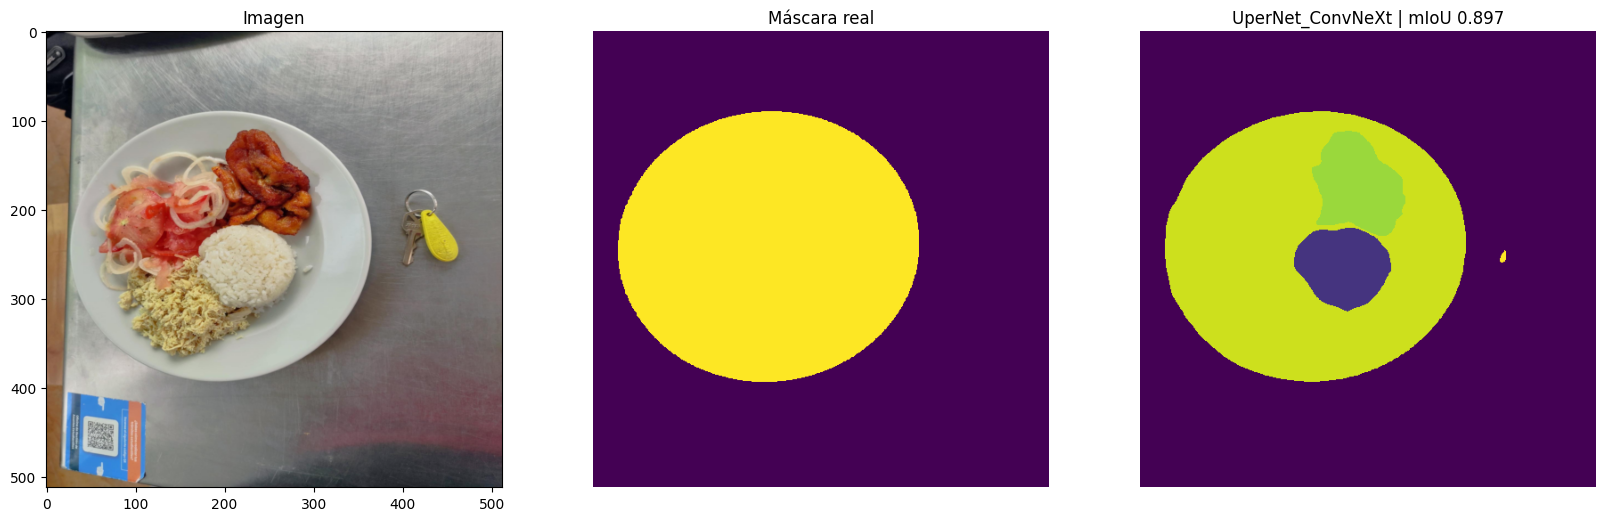

In [ ]:
image_rgb = unnormalize(image)
image_rgb = image_rgb.cpu().permute(1, 2, 0).numpy()
image_rgb = (image_rgb * 255).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image_rgb)
ax1.set_title('Imagen');

ax2.imshow(mask)
ax2.set_title('Máscara real')
ax2.set_axis_off()

ax3.imshow(pred_mask.squeeze(0))
ax3.set_title('UperNet_ConvNeXt | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

## Estimación de volumén

Cálculo del porcentaje de cobertura

In [ ]:
MAPA_EXCEPTION = {
   38 : "tag 6",
   39 : "tag 7",
   40 : "tag1",
   41 : "tag2",
   42 : "tag3",
   43 : "tag5",
   0 : "CarbsSet"
}

@dataclass
class ObjectException(Enum):
    TAG_4 = "tag 4"
    TAG_5 = "tag5"
    TAG_2 = "tag2" 
    CHOCLO = "choclo"
    AREPA_CHOCLO = "arepachoclo"

In [134]:
coco_json_path = '_annotations.dataset.coco.json'

with open(coco_json_path, 'r') as file:
    data = json.load(file)

MAPA_CATEGORIAS = {}

# Inicializar IDs especiales
clase_id_plato = None
clase_id_plato_pequeño = None
clase_id_bandeja = None

for category in data.get("categories", []):
    name = category["name"]
    cid = category["id"]

    # Excepciones según analisís del dataset, para mejorar rendimiento.
    if name == ObjectException.TAG_4:
        clase_id_plato = cid
        continue
    elif name == ObjectException.TAG_5:
        clase_id_plato_pequeño = cid
        continue
    elif name == ObjectException.TAG_2:
        clase_id_bandeja = cid
        continue
    elif name == ObjectException.CHOCLO:
        arepachoclo = next((c for c in data["categories"] if c["name"] == ObjectException.AREPA_CHOCLO), None)
        if arepachoclo:
            cid = arepachoclo["id"]

    elif cid in MAPA_EXCEPTION:
        continue

    MAPA_CATEGORIAS[cid] = name

# Mostrar resultados
print("MAPA_CATEGORIAS:", MAPA_CATEGORIAS)
print(f"clase_id_plato: {clase_id_plato}")
print(f"clase_id_plato_pequeño: {clase_id_plato_pequeño}")
print(f"clase_id_bandeja: {clase_id_bandeja}")

MAPA_CATEGORIAS: {1: 'almojabana', 2: 'arepa paisa', 3: 'choclo', 4: 'arepamaiz', 5: 'arepapequena', 6: 'arroz', 7: 'arrozconpollo', 8: 'banano', 9: 'bunuelo', 11: 'crep', 12: 'croissant', 13: 'empanadas', 14: 'fresas', 15: 'frijoles', 16: 'galleta', 17: 'garbanzos', 18: 'guineo', 19: 'hamburguesa', 20: 'leche', 21: 'lentejas', 22: 'mango', 23: 'manzana', 24: 'moras', 25: 'morcilla', 26: 'ochuva', 27: 'pan', 28: 'pan tajado', 29: 'papa comun', 30: 'papa criolla', 31: 'papas fritas', 32: 'pasta', 33: 'pizza', 34: 'platano', 35: 'sandia', 36: 'sopa', 44: 'tamal', 45: 'torta', 46: 'tostada', 47: 'uvas', 48: 'yuca'}
clase_id_plato: 37
clase_id_plato_pequeño: 43
clase_id_bandeja: 41


In [136]:
def extract_instances(mask, class_id):
    """
    Extrae máscaras binarias de instancias individuales de una clase específica.
    """
    # Binaria: solo donde esté esa clase
    binary_mask = (mask == class_id).astype(np.uint8)

    # Detectar componentes conectados (cada región = instancia)
    num_labels, labels = cv2.connectedComponents(binary_mask)

    instances = []
    for i in range(1, num_labels): 
        instance_mask = (labels == i).astype(np.uint8)
        instances.append(instance_mask)

    return instances

In [138]:
# Ruta a las máscaras predichas
mask_dir = "./imagenes_predichas"

# Para guardar resultados
resultados = []

for file_name in os.listdir(mask_dir):
    if not file_name.endswith(".png"):
        continue

    mask_path = os.path.join(mask_dir, file_name)
    mask = np.array(Image.open(mask_path))

    # Extraer la máscara binaria del plato
    instancias_plato = extract_instances(mask, clase_id_plato)
    if not instancias_plato:
        continue

    dish_mask = np.zeros_like(mask, dtype=np.uint8)

    for inst in instancias_plato:
        dish_mask = cv2.bitwise_or(dish_mask, inst)

    points = []

    # Extraer coordenadas (x, y) de todos los píxeles activos
    ys, xs = np.where(dish_mask > 0)
    points = np.stack([xs, ys], axis=1)
    hull = cv2.convexHull(points)

    # Dibujar la envolvente en una máscara vacía
    cv2.fillConvexPoly(dish_mask, hull, color=1)

    area_plato = dish_mask.sum()

    # Por cada clase conocida
    for class_id, nombre_clase in MAPA_CATEGORIAS.items():
        instancias = extract_instances(mask, class_id)
        if not instancias:
            continue

        area_clase = sum(inst.sum() for inst in instancias)
        porcentaje = round(area_clase / area_plato * 100, 2) if area_plato > 0 else 0

        if class_id == clase_id_plato_pequeño:
            porcentaje *= 1.5
        elif class_id == clase_id_bandeja:
            porcentaje *= 0.5

        resultados.append({
            "archivo": file_name,
            "clase": nombre_clase,
            "area_clase": area_clase,
            "area_plato": area_plato,
            "porcentaje": porcentaje,
            "n_instancias": len(instancias)
        })


# Mostrar resultados
df = pd.DataFrame(resultados)
print(df)

# Guardar
df.to_excel("metricas_cobertura_carbohidratos.xlsx", index=False)

             archivo         clase  area_clase  area_plato  porcentaje  \
0    mask_pred_6.png         arroz       15435      104231       14.81   
1    mask_pred_6.png      frijoles       47136      104231       45.22   
2    mask_pred_7.png         arroz       15766       28281       55.75   
3    mask_pred_7.png       galleta        1803       28281        6.38   
4    mask_pred_5.png   arepa paisa       17846       60484       29.51   
5    mask_pred_5.png        guineo          23       60484        0.04   
6    mask_pred_4.png         arroz       46916      197338       23.77   
7    mask_pred_4.png  papas fritas       26460      197338       13.41   
8    mask_pred_1.png     empanadas         131       85693        0.15   
9    mask_pred_1.png    pan tajado       16772       85693       19.57   
10   mask_pred_1.png       tostada         570       85693        0.67   
11   mask_pred_1.png          yuca          42       85693        0.05   
12   mask_pred_3.png     arepamaiz    

Look Up Table para determinar gramos del alimento

In [ ]:
# Cargar el csv LookUpTable
lookup_df = pd.read_csv("LookUpTable.csv")

lookup_df.set_index("nombre_clase", inplace=True)

In [140]:
segmentation_output = [{
    "nombre_clase": instancia["clase"],
    "cobertura_actual": float(instancia["porcentaje"]),
    "archivo_nombre": instancia["archivo"]
}
                       for instancia in resultados]
print(segmentation_output)

[{'nombre_clase': 'arroz', 'cobertura_actual': 14.81, 'archivo_nombre': 'mask_pred_6.png'}, {'nombre_clase': 'frijoles', 'cobertura_actual': 45.22, 'archivo_nombre': 'mask_pred_6.png'}, {'nombre_clase': 'arroz', 'cobertura_actual': 55.75, 'archivo_nombre': 'mask_pred_7.png'}, {'nombre_clase': 'galleta', 'cobertura_actual': 6.38, 'archivo_nombre': 'mask_pred_7.png'}, {'nombre_clase': 'arepa paisa', 'cobertura_actual': 29.51, 'archivo_nombre': 'mask_pred_5.png'}, {'nombre_clase': 'guineo', 'cobertura_actual': 0.04, 'archivo_nombre': 'mask_pred_5.png'}, {'nombre_clase': 'arroz', 'cobertura_actual': 23.77, 'archivo_nombre': 'mask_pred_4.png'}, {'nombre_clase': 'papas fritas', 'cobertura_actual': 13.41, 'archivo_nombre': 'mask_pred_4.png'}, {'nombre_clase': 'empanadas', 'cobertura_actual': 0.15, 'archivo_nombre': 'mask_pred_1.png'}, {'nombre_clase': 'pan tajado', 'cobertura_actual': 19.57, 'archivo_nombre': 'mask_pred_1.png'}, {'nombre_clase': 'tostada', 'cobertura_actual': 0.67, 'archivo_n

In [ ]:
def estimate_grams(nombre_clase, cobertura_actual, archivo,lookup_df):
    """
    Estima los gramos totales de alimento y de carbohidratos para una clase alimenticia específica,
    en función de su cobertura relativa y los valores de referencia presentes en una tabla LookUp.
    """
    
    try:
        ref = lookup_df.loc[nombre_clase]
    except KeyError:
        return {"nombre_clase": nombre_clase, "estimated_grams": None, "status": "class_not_found"}

    expected_cobertura = ref["cobertura_ref"]
    grams_ref = ref["gramos_ref"]
    gramos_carb_ref = ref["gramos_carb_ref"]

    if expected_cobertura == 0:
        return {"nombre_clase": nombre_clase, "estimated_grams": 0.0, "status": "invalid_reference"}


    ratio = cobertura_actual / float(str(expected_cobertura).replace(",", "."))
    scaled_grams = ratio * float(str(grams_ref).replace(",", "."))
    scaled_grams_carb = ratio * float(str(gramos_carb_ref).replace(",", "."))

    return {
        "nombre_clase": nombre_clase,
        "gramos estimados": round(scaled_grams, 2),
        "gramos estimados carb": round(scaled_grams_carb, 2),
        "ratio": round(ratio, 2),
        "archivo": archivo
    }


In [ ]:
results = []
for obj in segmentation_output:
    results.append(estimate_grams(obj["nombre_clase"], obj["cobertura_actual"], obj["archivo_nombre"], lookup_df))

df_results = pd.DataFrame(results)
df_summary = df_results.groupby("archivo").agg(
    total_carbs_g=("gramos estimados carb", "sum")
).reset_index()

with pd.ExcelWriter("estimated_carbs.xlsx") as writer:
    df_results.to_excel(writer, sheet_name="por_clase", index=False)
    df_summary.to_excel(writer, sheet_name="por_imagen", index=False)

print(" Resultados guardados en 'estimated_carbs.xlsx'")

 Resultados guardados en 'estimated_carbs.xlsx'


# Validación del pipeline

In [122]:
reference = [{
    "nombre_clase": "arroz",
    "reference_grams": 25,
    "archivo_nombre": "mask_pred_4.png"
},
{
    "nombre_clase": "papas fritas",
    "reference_grams": 12,
    "archivo_nombre": "mask_pred_4.png"
}
]

In [ ]:
def compute_ingredient_error(predicted_list, reference_list):
    """
    Calcula el error en gramos de carbohidratos entre las predicciones realizadas y los valores de referencia
    por clase de alimento, y devuelve una lista con la información detallada por instancia.
    """
    
    ref_map = {item["nombre_clase"]: item["reference_grams"] for item in reference_list}

    errors = []
    total_pred = 0
    total_ref = 0

    for item in predicted_list:
        name = item["nombre_clase"]
        pred_grams = item["gramos estimados carb"]
        ref_grams = ref_map.get(name)

        if ref_grams is None:
            error = None
        else:
            error = pred_grams - ref_grams 
            total_pred += pred_grams
            total_ref += ref_grams

        errors.append({
            "archivo": item.get("archivo"),
            "class_name": name,
            "gramos estimados carb": pred_grams,
            "reference_grams": ref_grams,
            "error_grams": round(error, 2) if error is not None else None,
        })

    return errors


In [129]:
errors = compute_ingredient_error(results, reference)
df = pd.DataFrame(errors)
print(df)

df_summary = df.groupby("archivo").agg(
    total_carbs_g_est=("gramos estimados carb", "sum"),
    total_carbs_g_ref=("reference_grams", "sum"),
).reset_index()
df_summary["porcentaje_error"] = round(
    abs(df_summary["total_carbs_g_est"] - df_summary["total_carbs_g_ref"]) / df_summary["total_carbs_g_ref"] * 100,
    2
)
print("Summary:", df_summary)

           archivo    class_name  gramos estimados carb  reference_grams  \
0  mask_pred_4.png         arroz                  29.48               25   
1  mask_pred_4.png  papas fritas                   9.41               12   

   error_grams  
0         4.48  
1        -2.59  
Summary:            archivo  total_carbs_g_est  total_carbs_g_ref  porcentaje_error
0  mask_pred_4.png              38.89                 37              5.11
